In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
# load dataset via shared google drive folder
df_fact_avail = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/fact_availability.csv')
df_hosts = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Final Dimension Model Tables/dim_hosts.csv')
df_TM_listings = pd.read_excel('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Processing/df_listings_topicmodelling_results.xlsx')
df_TM_reviews = pd.read_excel('/content/drive/MyDrive/BAP Practice Module/BAP Final Report/Data/Processing/df_reviews_topicmodelling_results.xlsx')

# # Alternative load data via local file upload
#df_fact_avail = pd.read_csv('fact_availability.csv')
#df_host = pd.read_csv('dim_hos0st.csv')
#df_TM_review = pd.read_excel('df_reviews_topicmodelling_results.xlsx')
#df_TM_listings = pd.read_excel('df_listings_topicmodelling_results.xlsx')

NameError: name 'pd' is not defined

In [ ]:
df_fact_avail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                2512 non-null   int64
 1   has_availability  2512 non-null   int64
 2   availability_30   2512 non-null   int64
 3   availability_60   2512 non-null   int64
 4   availability_90   2512 non-null   int64
 5   availability_365  2512 non-null   int64
dtypes: int64(6)
memory usage: 117.9 KB


In [ ]:
df_hosts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   host_id                                       2512 non-null   int64 
 1   host_since                                    2512 non-null   object
 2   host_location                                 2512 non-null   object
 3   host_about_tokens                             1845 non-null   object
 4   host_response_time                            2512 non-null   int64 
 5   host_response_rate                            2512 non-null   int64 
 6   host_acceptance_rate                          2512 non-null   int64 
 7   host_is_superhost                             2512 non-null   int64 
 8   host_neighbourhood                            2512 non-null   object
 9   host_listings_count                           2512 non-null   int64 
 10  

In [ ]:
df_TM_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39282 entries, 0 to 39281
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   listing_id          39282 non-null  int64         
 1   id                  39282 non-null  int64         
 2   date                39282 non-null  datetime64[ns]
 3   reviewer_id         39282 non-null  int64         
 4   reviewer_name       39282 non-null  object        
 5   comments_tokens     39282 non-null  object        
 6   topic_distribution  39282 non-null  object        
 7   dominant_topic      39282 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 2.4+ MB


In [ ]:
df_TM_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            2512 non-null   int64         
 1   host_id                       2512 non-null   int64         
 2   neighbourhood_cleansed        2512 non-null   object        
 3   neighbourhood_group_cleansed  2512 non-null   object        
 4   latitude                      2512 non-null   float64       
 5   longitude                     2512 non-null   float64       
 6   room_type                     2512 non-null   int64         
 7   accommodates                  2512 non-null   int64         
 8   bathrooms                     2512 non-null   float64       
 9   bedrooms                      2512 non-null   int64         
 10  beds                          2512 non-null   int64         
 11  amenities                     

In [ ]:
# combine listings and fact_availability table
df_combi = df_TM_listings.merge(df_fact_avail, on='id', how='left')

# fill nan with 0
df_combi.fillna(0, inplace=True)
df_combi.head()

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,host_about_tokens,listing rating category,combined_tokens,topic_distribution,dominant_topic,has_availability,availability_30,availability_60,availability_90,availability_365
0,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,"['k2', 'guesthouse', 'designed', 'guests', 'wa...",low,"['10min', 'walk', 'mrt', 'cozy', 'room', 'wind...","[(0, 0.082711875), (2, 0.9123482)]",2,1.0,0.0,0.0,0.0,56.0
1,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,"['k2', 'guesthouse', 'designed', 'guests', 'wa...",low,"['10min', 'walk', 'mrt', 'cozy', 'room', 'wind...","[(0, 0.082711875), (2, 0.9123482)]",2,1.0,0.0,0.0,0.0,56.0
2,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,"['k2', 'guesthouse', 'designed', 'guests', 'wa...",low,"['10min', 'walk', 'mrt', 'cozy', 'room', 'wind...","[(0, 0.08271377), (2, 0.9123463)]",2,1.0,0.0,0.0,0.0,56.0
3,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,"['k2', 'guesthouse', 'designed', 'guests', 'wa...",low,"['10min', 'walk', 'mrt', 'cozy', 'room', 'wind...","[(0, 0.08271377), (2, 0.9123463)]",2,1.0,0.0,0.0,0.0,56.0
4,275344,1439258,Bukit Merah,Central Region,1.28883,103.81113,3,1,2.5,1,...,"['k2', 'guesthouse', 'designed', 'guests', 'wa...",low,"['15', 'mins', 'outram', 'mrt', 'single', 'roo...","[(0, 0.015014555), (2, 0.97796637)]",2,1.0,0.0,0.0,0.0,56.0


In [ ]:
# combine df_combi with hosts table
df_combi2 = df_combi.merge(df_hosts, on='host_id', how='left')
df_combi2.head()

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,51,77,"['email', 'phone']",1,1,S0399,51,0,51,0
1,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,51,77,"['email', 'phone']",1,1,S0399,51,0,51,0
2,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,51,77,"['email', 'phone']",1,1,S0399,51,0,51,0
3,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,51,77,"['email', 'phone']",1,1,S0399,51,0,51,0
4,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,51,77,"['email', 'phone']",1,1,S0399,51,0,51,0


# Sentiment Analysis

In [ ]:
# Sentiment analysis function using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series({
        'polarity': blob.sentiment.polarity,           # [-1.0, 1.0]
        'subjectivity': blob.sentiment.subjectivity    # [0.0, 1.0]
    })

# Apply sentiment function
sentiments = df_TM_reviews['comments_tokens'].apply(get_sentiment)

# Merge sentiment results into original dataframe
df_TM_reviews = pd.concat([df_TM_reviews, sentiments], axis=1)

# Categorize the polarity into sentiment labels
df_TM_reviews['sentiment_label'] = df_TM_reviews['polarity'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral'
)

# Save results to a new Excel file
output_file = 'df_reviews_with_sentiment.xlsx'
df_TM_reviews.to_excel(output_file, index=False)

print(f"Sentiment analysis saved to {output_file}")

Sentiment analysis saved to df_reviews_with_sentiment.xlsx


# Merge reviews and listings

In [ ]:
# rename dominant_topic to LTopic
df_combi2.rename(columns={'dominant_topic': 'LTopic'}, inplace=True)
df_combi2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135868 entries, 0 to 135867
Data columns (total 66 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   id                                            135868 non-null  int64         
 1   host_id                                       135868 non-null  int64         
 2   neighbourhood_cleansed                        135868 non-null  object        
 3   neighbourhood_group_cleansed                  135868 non-null  object        
 4   latitude                                      135868 non-null  float64       
 5   longitude                                     135868 non-null  float64       
 6   room_type                                     135868 non-null  int64         
 7   accommodates                                  135868 non-null  int64         
 8   bathrooms                                     135868 n

In [ ]:
# rename dominant_topic to RTopic
df_TM_reviews.rename(columns={'dominant_topic': 'RTopic'}, inplace=True)

# merge df_TM_reviews into df_combi
df_combi3 = df_combi2.merge(df_TM_reviews, left_on='id', right_on='listing_id', how='left')

# drop id_y rename id_x as id
df_combi3.drop(columns=['id_y'], inplace=True)
df_combi3.rename(columns={'id_x': 'id'}, inplace=True)

# for sentiment that are blank, replace as unknown
df_combi3.fillna({'sentiment_label': 'unknown'}, inplace=True)

df_combi3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544321 entries, 0 to 544320
Data columns (total 76 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   id                                            544321 non-null  int64         
 1   host_id                                       544321 non-null  int64         
 2   neighbourhood_cleansed                        544321 non-null  object        
 3   neighbourhood_group_cleansed                  544321 non-null  object        
 4   latitude                                      544321 non-null  float64       
 5   longitude                                     544321 non-null  float64       
 6   room_type                                     544321 non-null  int64         
 7   accommodates                                  544321 non-null  int64         
 8   bathrooms                                     544321 n

# Get Price Range & Occupancy Rate

In [ ]:
# get price_range using df_combi2

df_combi3['price_range'] = pd.cut(df_combi3['price'], bins=[0, 100, 200, 300, 500, 1000, float('inf')],
                                     labels=['0-100', '101-200', '201-300', '301-500', '501-1000', '>1000'])

df_combi3.head()

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,date,reviewer_id,reviewer_name,comments_tokens,topic_distribution_y,RTopic,polarity,subjectivity,sentiment_label,price_range
0,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,2013-04-20,5492044.0,Carol,"['newly', 'renovated', 'clean', 'apartment', '...","[(0, 0.2336819), (2, 0.24025296), (6, 0.150271...",9.0,0.219508,0.413636,positive,0-100
1,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,2013-11-19,7938877.0,Ying,"['glad', 'chose', 'place', 'joyce', 'family', ...","[(2, 0.82239646), (9, 0.13053454)]",2.0,0.322222,0.627778,positive,0-100
2,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,2015-02-20,18071761.0,誼勳,"['enjoyed', 'time', 'shared', 'woons', 'joyce'...","[(2, 0.695943), (6, 0.13288167), (7, 0.14617462)]",2.0,0.244444,0.616667,positive,0-100
3,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,2015-03-21,26579851.0,David,"['woons', 'nice', 'welcoming', 'people', 'grea...","[(0, 0.064363986), (1, 0.20126975), (2, 0.4648...",2.0,0.662500,0.770833,positive,0-100
4,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,2015-06-14,29892169.0,Jessica,"['stayed', 'woon', 'family', '3', 'weeks', 'ma...","[(0, 0.09055144), (1, 0.15764573), (2, 0.22732...",2.0,0.249242,0.403030,positive,0-100


In [ ]:
# compute occupancy rate
df_combi3['occupancy_rate'] = 1 - (df_combi3['availability_365'] / 365)
df_combi3.head()

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,reviewer_id,reviewer_name,comments_tokens,topic_distribution_y,RTopic,polarity,subjectivity,sentiment_label,price_range,occupancy_rate
0,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,5492044.0,Carol,"['newly', 'renovated', 'clean', 'apartment', '...","[(0, 0.2336819), (2, 0.24025296), (6, 0.150271...",9.0,0.219508,0.413636,positive,0-100,0.846575
1,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,7938877.0,Ying,"['glad', 'chose', 'place', 'joyce', 'family', ...","[(2, 0.82239646), (9, 0.13053454)]",2.0,0.322222,0.627778,positive,0-100,0.846575
2,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,18071761.0,誼勳,"['enjoyed', 'time', 'shared', 'woons', 'joyce'...","[(2, 0.695943), (6, 0.13288167), (7, 0.14617462)]",2.0,0.244444,0.616667,positive,0-100,0.846575
3,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,26579851.0,David,"['woons', 'nice', 'welcoming', 'people', 'grea...","[(0, 0.064363986), (1, 0.20126975), (2, 0.4648...",2.0,0.662500,0.770833,positive,0-100,0.846575
4,275343,1439258,Bukit Merah,Central Region,1.28986,103.80948,3,1,2.0,1,...,29892169.0,Jessica,"['stayed', 'woon', 'family', '3', 'weeks', 'ma...","[(0, 0.09055144), (1, 0.15764573), (2, 0.22732...",2.0,0.249242,0.403030,positive,0-100,0.846575


# Data Exploration

### Correlation Analysis

Highly Correlated Variables:
                                      Variable 1  \
14                        minimum_minimum_nights   
15                        maximum_minimum_nights   
4                         maximum_minimum_nights   
13                                minimum_nights   
0                         minimum_minimum_nights   
1                         maximum_minimum_nights   
93                           host_listings_count   
10                        maximum_nights_avg_ntm   
27                        review_scores_accuracy   
54                         review_scores_checkin   
52                        review_scores_accuracy   
28                     review_scores_cleanliness   
30                   review_scores_communication   
63                          review_scores_rating   
64                        review_scores_accuracy   
61                   review_scores_communication   
40                        review_scores_accuracy   
31                        review_sc

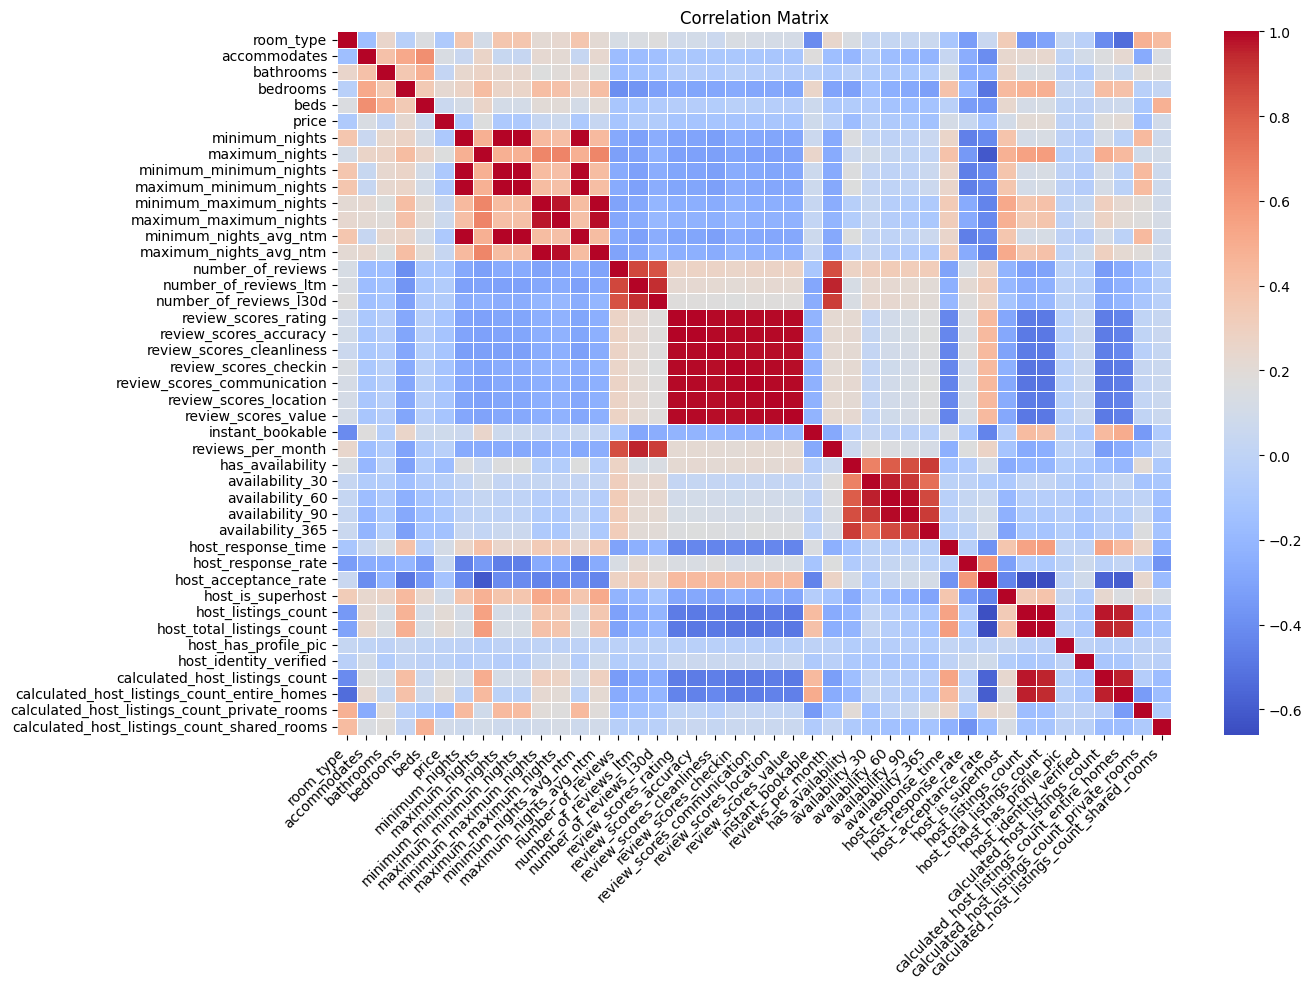

In [ ]:
# remove features not required in correlation
columns_drop = ['id', 'host_id', 'longitude', 'latitude',
                'neighbourhood_cleansed',
                'neighbourhood_group_cleansed', 'first_review' , 'last_review',
                'name_tokens', 'description_tokens', 'neighborhood_overview_tokens',
                'host_about_tokens_x', 'host_about_tokens_y',
                'listing rating category', 'combined_tokens',
                'topic_distribution_x', 'topic_distribution_y', 'LTopic', 'date',
                'reviewer_id', 'reviewer_name', 'comments_tokens', 'RTopic',
                'polarity', 'subjectivity', 'sentiment_label', 'price_range',
                'occupancy_rate', 'listing_id', 'license', 'host_verifications']

df_correl = df_combi3.drop(columns=columns_drop)

# check correlation
corr_matrix = df_correl.corr(numeric_only=True)

highly_correlated_pairs = []

## iterate through the correlation matrix to extract the pairs with correlation > 0.7 or any threshold you prefer
threshold = 0.7
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if abs(corr_matrix.loc[row, col]) > threshold and row != col:
            highly_correlated_pairs.append([row, col, corr_matrix.loc[row, col]])

highly_correlated_df = pd.DataFrame(highly_correlated_pairs,
                                    columns=['Variable 1', 'Variable 2', 'Correlation'])

## remove duplicate pairs by making sure (x, y) and (y, x) are not both present
highly_correlated_df = highly_correlated_df[highly_correlated_df['Variable 1']
                                            < highly_correlated_df['Variable 2']]
## sort the pairs by correlation value in descending order
highly_correlated_df = highly_correlated_df.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Variables:")
print(highly_correlated_df)

## correlation plot
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5,
            xticklabels=True, yticklabels=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Prediction Model

## Further Data Preparation

In [ ]:
# use df_pred to further prepare here
df_pred = df_combi3

In [ ]:
# convert 'neighboourhood_cleansed' into numerical label
le = LabelEncoder()
df_pred['neighbourhood_cleansed'] = le.fit_transform(df_pred['neighbourhood_cleansed'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

## to save category assigned for future use
import pickle

# save encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# load encoder later
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16), np.int64(17): np.int64(17), np.int64(18): np.int64(18), np.int64(19): np.int64(19), np.int64(20): np.int64(20), np.int64(21): np.int64(21), np.int64(22): np.int64(22), np.int64(23): np.int64(23), np.int64(24): np.int64(24), np.int64(25): np.int64(25), np.int64(26): np.int64(26), np.int64(27): np.int64(27), np.int64(28): np.int64(28), np.int64(29): np.int64(29), np.int64(30): np.int64(30), np.int64(31): np.int64(31), np.int64(32): np.int64(32), np.int64(33): np.int64(33), np.int64(34): np.int64(34), np.int64(35): np.int64(35), np.int64(36

In [ ]:
# one-hot encoding for 'amenities' attribute
df = df_pred['amenities']

# convert string to list
df = df.apply(lambda x: x.replace('"', '').split(','))

# count top N amenities
top_n = 50
amenity_counts = Counter([a.strip() for sublist in df for a in sublist])
top_amenities = set([a for a, count in amenity_counts.most_common(top_n)])

# create a binary matrix for top amenities
df_encoded = df.apply(lambda x: {a.strip(): 1 for a in x if a.strip() in top_amenities})
df_encoded = df_encoded.apply(pd.Series).fillna(0).astype(int)

# combine back into df_pred
df_pred = pd.concat([df_pred, df_encoded], axis=1)

In [ ]:
# drop 'amenities' attribute
df_pred = df_pred.drop(columns=['amenities'])

In [ ]:
# convert 'first_review' date into days from today (last run 18 Apr 2025)
df_pred['first_review'] = pd.to_datetime(df_pred['first_review'])
df_pred['days_since_first_review'] = (datetime.today() - df_pred['first_review']).dt.days

In [ ]:
# convert 'last_review' data into days from today
df_pred['last_review'] = pd.to_datetime(df_pred['last_review'])
df_pred['days_since_last_review'] = (datetime.today() - df_pred['last_review']).dt.days

In [ ]:
# convert 'host_since' data into days from today
df_pred['host_since'] = pd.to_datetime(df_pred['host_since'])
df_pred['days_from_host_since'] = (datetime.today() - df_pred['host_since']).dt.days

In [ ]:
# drop 'first_review' & 'last_review' & 'host_since' date
df_pred = df_pred.drop(columns=['first_review'])
df_pred = df_pred.drop(columns=['last_review'])
df_pred = df_pred.drop(columns=['host_since'])

In [ ]:
# price range with dummy values
price_band_mapping = {
    '0-100': 0,
    '101-200': 1,
    '201-300': 2,
    '301-500': 3,
    '501-1000': 4,
    '>1000': 5
}

# apply the mapping
df_pred['price_range_coded'] = df_pred['price_range'].map(price_band_mapping)

# fill empty with 0
df_pred.fillna({'price_range_coded': 0}, inplace=True)

In [ ]:
# convert 'listing rating category' into numerical label
list_rating_mapping = {
    'high': 1,
    'low': 0,
}

# apply the mapping
df_pred['listing_rating_cat'] = df_pred['listing rating category'].map(list_rating_mapping)

# fill empty with 0
df_pred.fillna({'listing_rating_cat': 0}, inplace=True)
df_pred.drop(columns=['listing rating category'])

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,Cleaning available during stay,Iron,Free washer \u2013 In building,Free dryer \u2013 In building,Safe],days_since_first_review,days_since_last_review,days_from_host_since,price_range_coded,listing_rating_cat
0,275343,1439258,4,Central Region,1.28986,103.809480,3,1,2.0,1,...,0,0,0,0,0,4381,979,4894,0,0
1,275343,1439258,4,Central Region,1.28986,103.809480,3,1,2.0,1,...,0,0,0,0,0,4381,979,4894,0,0
2,275343,1439258,4,Central Region,1.28986,103.809480,3,1,2.0,1,...,0,0,0,0,0,4381,979,4894,0,0
3,275343,1439258,4,Central Region,1.28986,103.809480,3,1,2.0,1,...,0,0,0,0,0,4381,979,4894,0,0
4,275343,1439258,4,Central Region,1.28986,103.809480,3,1,2.0,1,...,0,0,0,0,0,4381,979,4894,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544316,1252083926209830912,238891646,21,Central Region,1.30670,103.830934,1,2,1.0,1,...,0,0,0,0,0,9604,9604,2275,2,0
544317,1253501537875000064,265191783,11,Central Region,1.31326,103.892270,1,4,2.0,2,...,0,0,0,0,0,9604,9604,2150,1,0
544318,1253501537875000064,265191783,11,Central Region,1.31326,103.892270,1,4,2.0,2,...,0,0,0,0,0,9604,9604,2150,1,0
544319,1253501537875000064,265191783,11,Central Region,1.31326,103.892270,1,4,2.0,2,...,0,0,0,0,0,9604,9604,2150,1,0


In [ ]:
# one hot encode RTopic to see how many unique review has that topic has
df_Rtopic_counts = (
    df_pred.groupby(['id', 'RTopic'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('Rtopic_')
    .reset_index()
)

df_Rtopic_counts.fillna(0, inplace=True)

## merge the topic features back to the original data
df_pred = df_pred.drop_duplicates(subset='id')
df_pred = df_pred.merge(df_Rtopic_counts, on='id', how='left')

rtopic_cols = [col for col in df_pred.columns if col.startswith('Rtopic_')]
df_pred[rtopic_cols] = df_pred[rtopic_cols].fillna(0)

In [ ]:
# one hot encode LTopic to see how many unique review has that topic has
df_Ltopic_counts = (
    df_pred.groupby(['id', 'RTopic'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('Ltopic_')
    .reset_index()
)

df_Ltopic_counts.fillna(0, inplace=True)

## merge the topic features back to the original data
df_pred = df_pred.drop_duplicates(subset='id')
df_pred = df_pred.merge(df_Ltopic_counts, on='id', how='left')

ltopic_cols = [col for col in df_pred.columns if col.startswith('Ltopic_')]
df_pred[ltopic_cols] = df_pred[ltopic_cols].fillna(0)

In [ ]:
# dummy code sentiment_label
senti_mapping = {
    'unknown': 0,
    'negative': 1,
    'neutral': 2,
    'postive': 3,
}

# apply the mapping
df_pred['sentiment'] = df_pred['sentiment_label'].map(senti_mapping)

# fill empty with 0
df_pred.fillna({'sentiment': 0}, inplace=True)

df_pred.drop(columns=['sentiment_label'])

,id,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,Ltopic_1.0,Ltopic_2.0,Ltopic_3.0,Ltopic_4.0,Ltopic_5.0,Ltopic_6.0,Ltopic_7.0,Ltopic_8.0,Ltopic_9.0,sentiment
0,275343,1439258,4,Central Region,1.289860,103.809480,3,1,2.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,275344,1439258,4,Central Region,1.288830,103.811130,3,1,2.5,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,294281,1521514,19,Central Region,1.311420,103.839240,3,2,1.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,324945,1439258,4,Central Region,1.288280,103.810200,3,1,2.0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,330095,1439258,4,Central Region,1.286360,103.811380,3,1,2.0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,1250286484789552128,229617427,26,Central Region,1.299169,103.835624,1,1,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2452,1250306191413063936,1439258,25,Central Region,1.279710,103.787510,3,1,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2453,1250664127604301056,238891646,21,Central Region,1.307513,103.832948,1,4,2.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,1252083926209830912,238891646,21,Central Region,1.306700,103.830934,1,2,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# see columns in df_pred in a list
df_pred.columns.tolist()

['id',
 'host_id',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'name_tokens',
 'description_tokens',
 'neighborhood_overview_tokens',
 'host_about_tokens_x',
 'listing rating category',
 'combined_tokens',
 'topic_distribution_x',
 'LTopic',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'host_location',
 'host_a

In [ ]:
# drop features not required in predictive model
## based off correlation chart and domain knowledge

columns_drop1 = ['id', 'host_id', 'longitude', 'latitude',
                'neighbourhood_group_cleansed', 'price',
                'name_tokens', 'description_tokens', 'neighborhood_overview_tokens',
                'host_about_tokens_x', 'host_about_tokens_y',
                'listing rating category', 'combined_tokens',
                'topic_distribution_x', 'topic_distribution_y', 'host_location',
                'date', 'host_neighbourhood',
                'host_verifications', 'license', 'calculated_host_listings_count',
                'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'reviewer_id', 'reviewer_name', 'comments_tokens',
                'polarity', 'subjectivity', 'minimum_minimum_nights',
                'maximum_minimum_nights','minimum_maximum_nights',
                'maximum_maximum_nights', 'review_scores_accuracy', 'review_scores_cleanliness',
                'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'review_scores_value',
                'availability_30', 'availability_60', 'availability_90',
                'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                'number_of_reviews', 'has_availability', 'listing_id', 'LTopic',
                 'RTopic','sentiment_label', 'price_range', 'host_listings_count']

df_predf = df_pred.drop(columns=columns_drop1)

# change price_range_coded into numerical
df_predf['price_range_coded'] = pd.to_numeric(df_predf['price_range_coded'], errors='coerce')

In [ ]:
# export df_pred
df_predf.to_csv('df_pred.csv', index=False)

## Predictive Model

In [ ]:
# train-test split
X = df_predf.drop(columns=['occupancy_rate'])
y = df_predf['occupancy_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# train models linear regression, random forest, gradient boosting

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'MSE': mse, 'R2': r2}

# show results
for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")

Linear Regression - MSE: 0.0909, R2: 0.5618
Random Forest - MSE: 0.0441, R2: 0.7876
Gradient Boosting - MSE: 0.0562, R2: 0.7289


In [ ]:
# optimize random forest (hyper parameter tuning)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (neg MSE):", grid_search.best_score_)

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score (neg MSE): -0.05308209475948032


In [ ]:
# evaluate on test set
best_model = grid_search.best_estimator_

# predict on the test set
y_pred = best_model.predict(X_test)

# evaluate performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Random Forest - MSE: {mse:.4f}, R2: {r2:.4f}")

Optimized Random Forest - MSE: 0.0421, R2: 0.7971


In [ ]:
# get feature importances from the trained model
importances = best_model.feature_importances_

# Ensure feature names match X_train columns
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

                           Feature    Importance
9           maximum_nights_avg_ntm  1.493707e-01
70         days_since_first_review  1.237727e-01
7                   maximum_nights  1.163966e-01
56                Private entrance  6.164316e-02
72            days_from_host_since  5.883708e-02
..                             ...           ...
90                      Ltopic_5.0  2.829986e-04
67  Free washer \u2013 In building  1.891471e-04
89                      Ltopic_4.0  6.805288e-05
68   Free dryer \u2013 In building  1.672592e-05
88                      Ltopic_3.0  2.193925e-07

[96 rows x 2 columns]


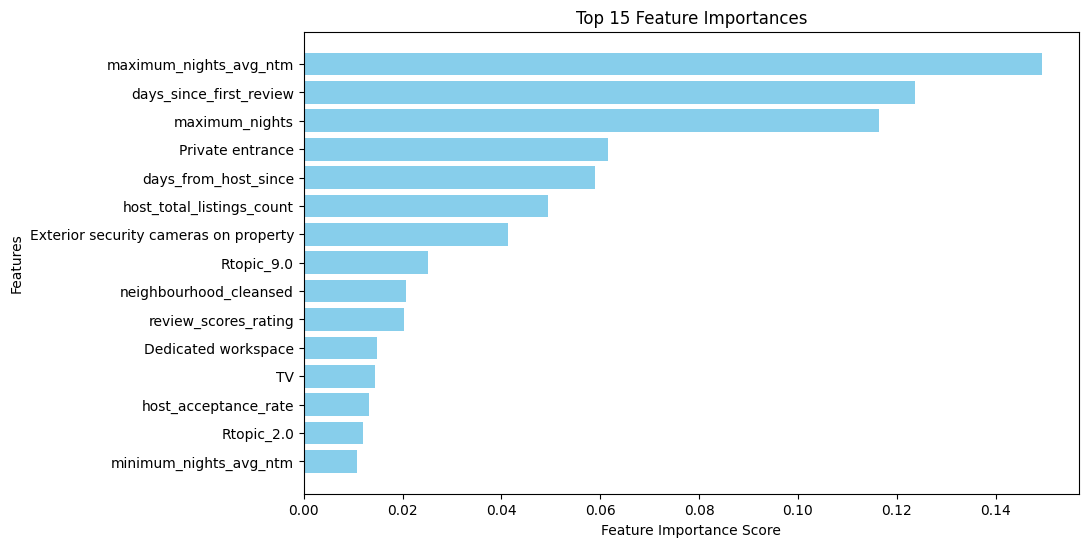

In [ ]:
# sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# display top features
print(feature_importance_df)

# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15], color='skyblue')
plt.gca().invert_yaxis()  # Invert axis to show highest at top
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 15 Feature Importances")
plt.show()

# Visualisations

## Bar Chart - occupancy rate vs neighbourhood


Average Occupancy Rate by Neighbourhood:
neighbourhood_cleansed
Marina South               1.000000
Tuas                       1.000000
Western Water Catchment    1.000000
Sungei Kadut               1.000000
Museum                     0.824359
Toa Payoh                  0.796807
Bukit Panjang              0.769080
Choa Chu Kang              0.762765
Marine Parade              0.733063
Punggol                    0.710372
Orchard                    0.665596
River Valley               0.639870
Sengkang                   0.542466
Bishan                     0.505099
Bukit Merah                0.484540
Rochor                     0.470284
Novena                     0.425643
Queenstown                 0.421426
Clementi                   0.420073
Jurong East                0.399603
Outram                     0.386816
Newton                     0.352721
Tanglin                    0.310435
Yishun                     0.301317
Geylang                    0.297406
Kallang                    0.291152

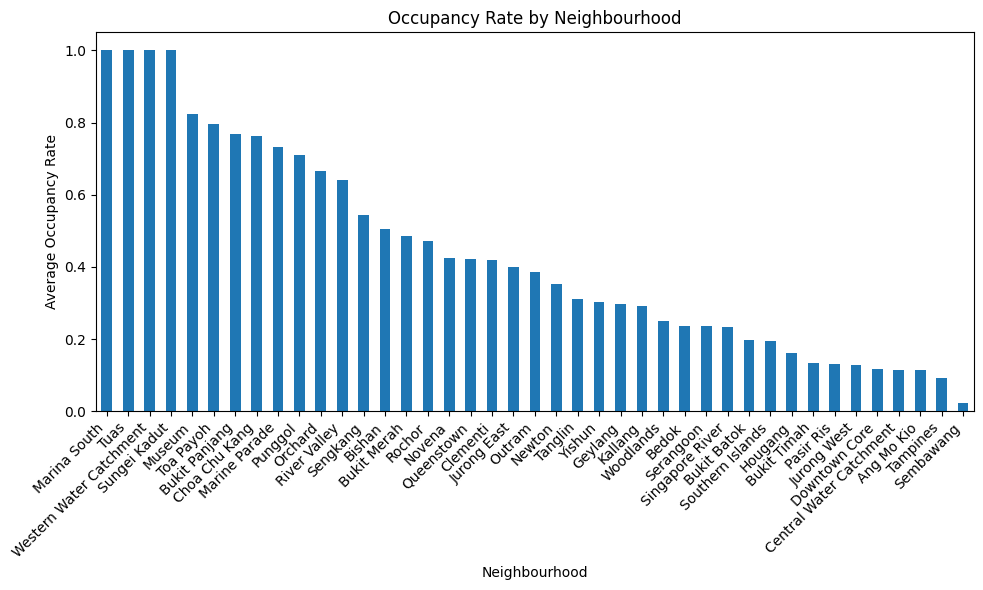

In [ ]:
location_occupancy = df_combi3.groupby('neighbourhood_cleansed')['occupancy_rate'].mean().sort_values(ascending=False)
print("\nAverage Occupancy Rate by Neighbourhood:")
print(location_occupancy)

plt.figure(figsize=(10, 6))
location_occupancy.plot(kind='bar')
plt.xlabel("Neighbourhood")
plt.ylabel("Average Occupancy Rate")
plt.title("Occupancy Rate by Neighbourhood")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Bar chart - number of listings per neighborhood

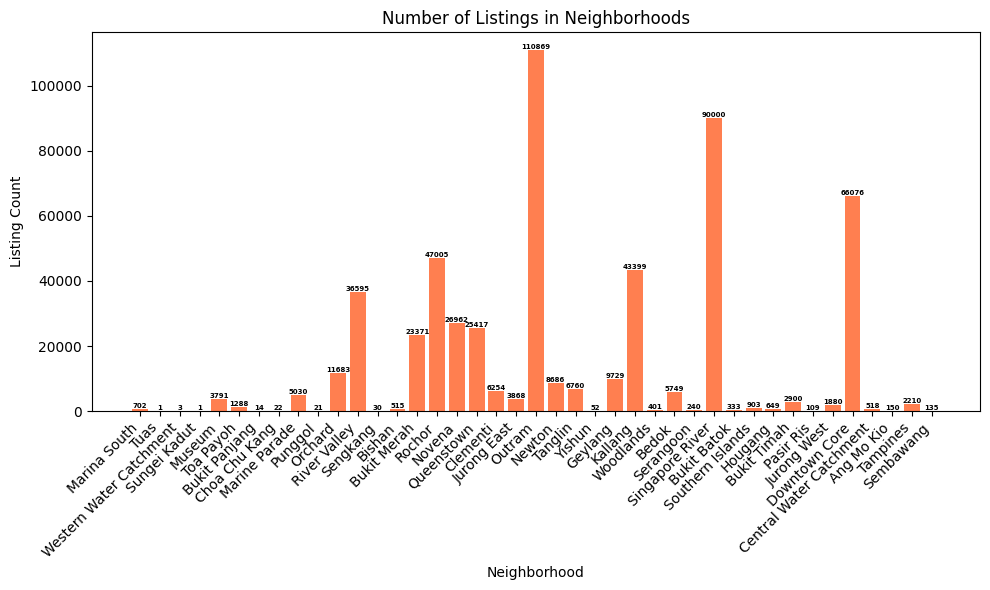

In [ ]:
# Group by neighborhood and calculate average occupancy
top_occupancy = (
    df_combi3.groupby('neighbourhood_cleansed')['occupancy_rate']
    .mean()
    .sort_values(ascending=False)
)

# Get listing counts for the top neighborhoods
top_listing_counts = df_combi3[df_combi3['neighbourhood_cleansed'].isin(top_occupancy.index)] \
    .groupby('neighbourhood_cleansed')['id'] \
    .count() \
    .reindex(top_occupancy.index)  # To match the order of occupancy

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(top_listing_counts.index, top_listing_counts.values, color='coral')
plt.title('Number of Listings in Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Listing Count')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        height + 1,  # Y position (slightly above bar)
        str(int(height)),  # Label text
        ha='center', va='bottom', fontsize=5, fontweight='bold'
    )

plt.tight_layout()
plt.show()

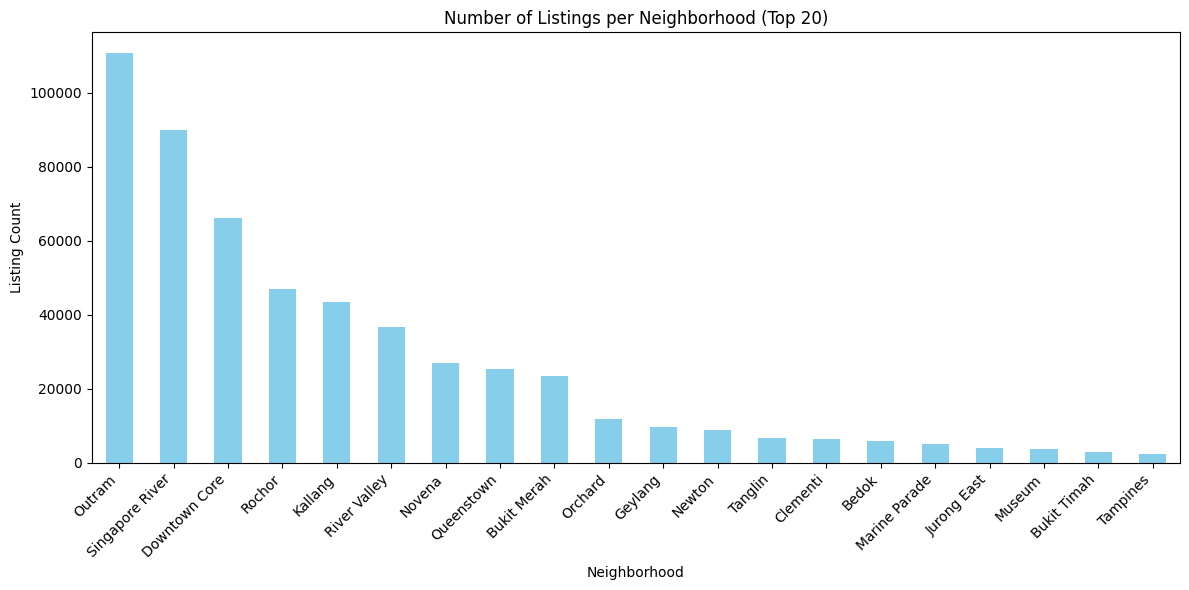

In [ ]:
listing_counts = df_combi3['neighbourhood_cleansed'].value_counts().sort_values(ascending=False).head(20)
listing_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Number of Listings per Neighborhood (Top 20)')
plt.ylabel('Listing Count')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Bubble chart - average occupancy rate vs number of listings

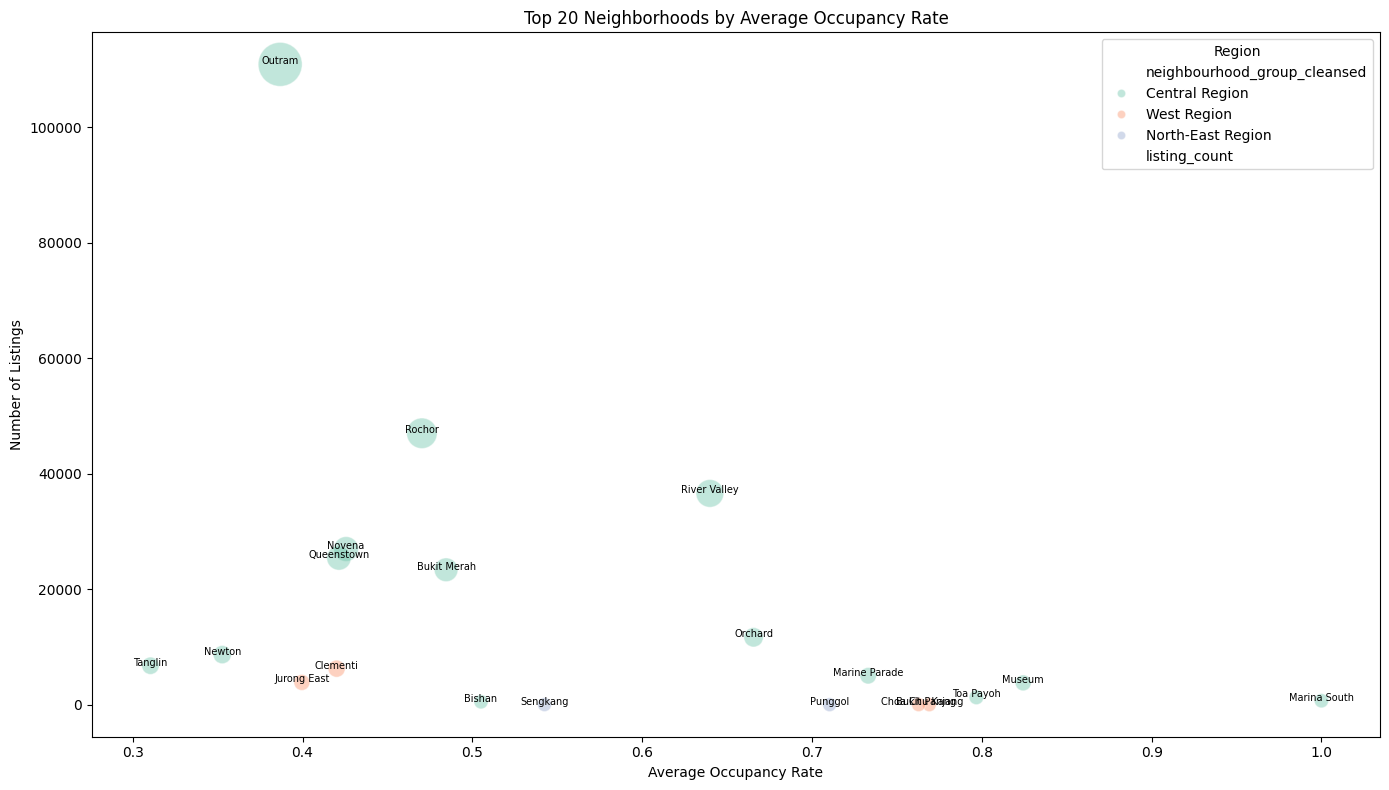

In [ ]:
# group by neighborhood and region
bubble_data = df_combi3.groupby(['neighbourhood_cleansed', 'neighbourhood_group_cleansed']).agg(
    avg_occupancy=('occupancy_rate', 'mean'),
    listing_count=('id', 'count')
).reset_index()

# filter to neighborhoods with at least 10 listings (optional to avoid tiny sample bias)
bubble_data = bubble_data[bubble_data['listing_count'] >= 10]

# get top 20 neighborhoods by avg occupancy
top20_bubble = bubble_data.sort_values('avg_occupancy', ascending=False).head(20)

# plot
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=top20_bubble,
    x='avg_occupancy',
    y='listing_count',
    size='listing_count',
    hue='neighbourhood_group_cleansed',
    palette='Set2',
    sizes=(100, 1000),
    alpha=0.4,
    legend='full'
)

# remove size legend entries, keep color only
handles, labels = scatter.get_legend_handles_labels()

# keep only hue legend (remove numeric size entries)
filtered = [(h, l) for h, l in zip(handles, labels) if not l.isnumeric()]
if scatter.legend_:
    scatter.legend_.remove()
plt.legend(*zip(*filtered), title='Region', loc='best')

# Add labels
for i in range(top20_bubble.shape[0]):
    row = top20_bubble.iloc[i]
    plt.text(
        row['avg_occupancy'],
        row['listing_count'] + 2,
        row['neighbourhood_cleansed'],
        fontsize=7,
        ha='center'
    )

plt.title('Top 20 Neighborhoods by Average Occupancy Rate')
plt.xlabel('Average Occupancy Rate')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

## Bar Chart - occupancy vs price ranges

<ipython-input-15-72e41e3af376>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_range_occupancy = df_combi3.groupby('price_range')['occupancy_rate'].mean()



Average Occupancy Rate by Price Range:
price_range
0-100       0.282696
101-200     0.196731
201-300     0.443703
301-500     0.666162
501-1000    0.535300
>1000       0.296537
Name: occupancy_rate, dtype: float64


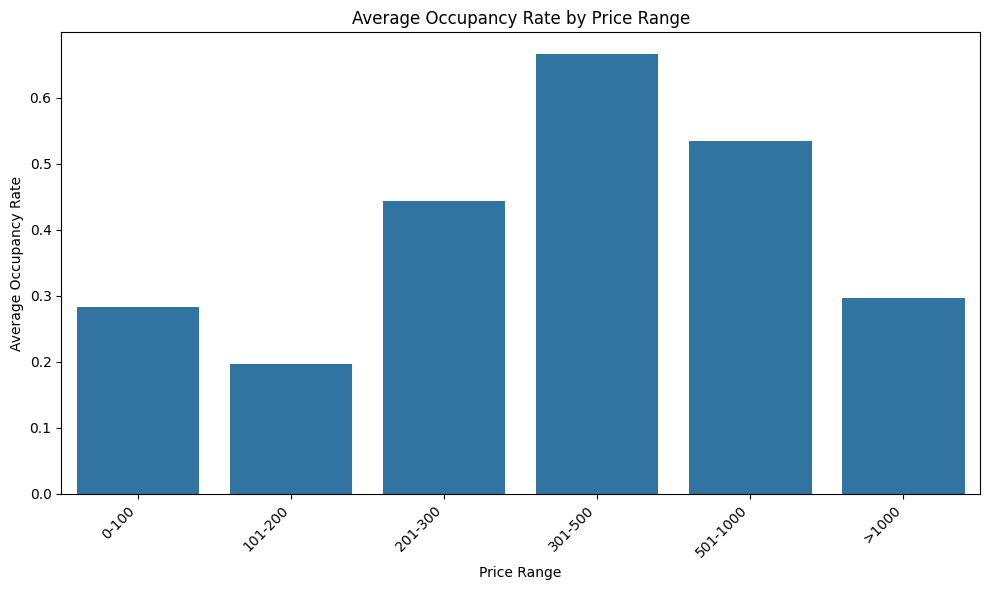

In [ ]:
# calculate Occupancy by Price Range
price_range_occupancy = df_combi3.groupby('price_range')['occupancy_rate'].mean()

print("\nAverage Occupancy Rate by Price Range:")
print(price_range_occupancy)

# visualization for Price Range Occupancy
plt.figure(figsize=(10, 6))
sns.barplot(x=price_range_occupancy.index, y=price_range_occupancy.values)
plt.title('Average Occupancy Rate by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Average Occupancy Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Bar chart - number of rooms & location vs price

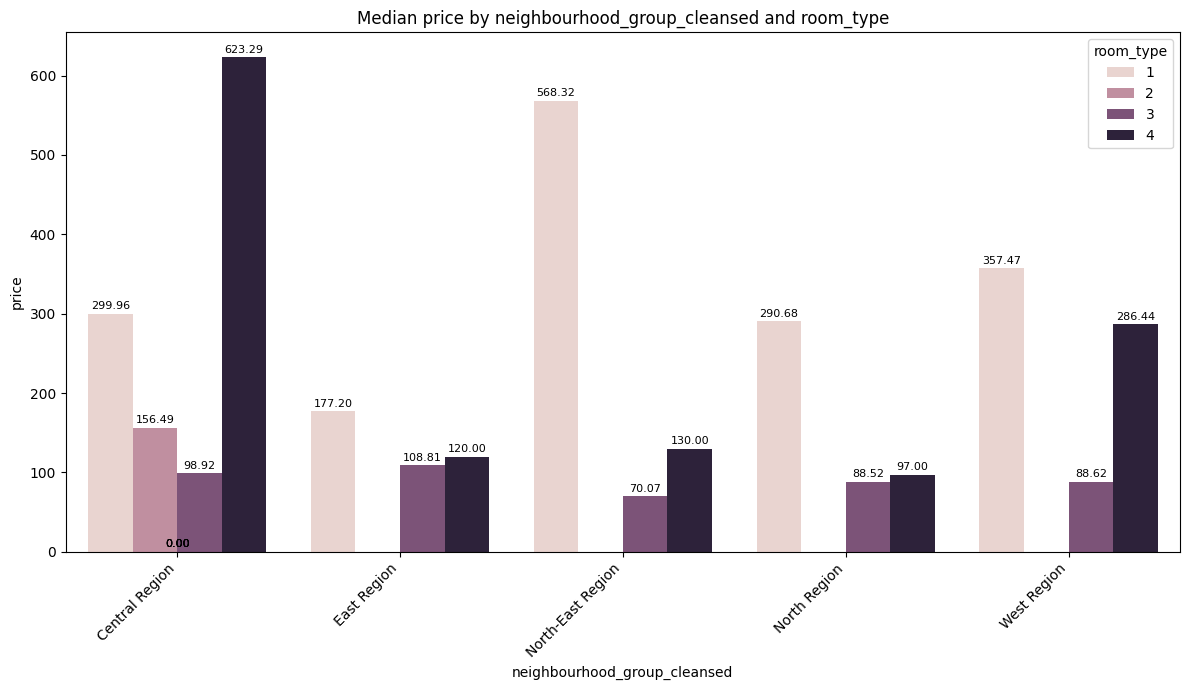

In [ ]:
# plot bar chart
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=df_combi3,
                   x='neighbourhood_group_cleansed',
                   y='price',
                   hue='room_type',
                   estimator=np.mean,
                   errorbar=None)
plt.title('Median price by neighbourhood_group_cleansed and room_type')
plt.xlabel('neighbourhood_group_cleansed')
plt.ylabel('price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):  # Check if height is not NaN
        ax.text(p.get_x() + p.get_width() / 2., height + 3,  # Adjust vertical offset (e.g., +3)
                f'{height:.2f}',  # Format the label (e.g., 2 decimal places)
                 ha='center', va='bottom', fontsize=8)  # Adjust text alignment and size

plt.show()

## Heat map - price by region and room tyoe

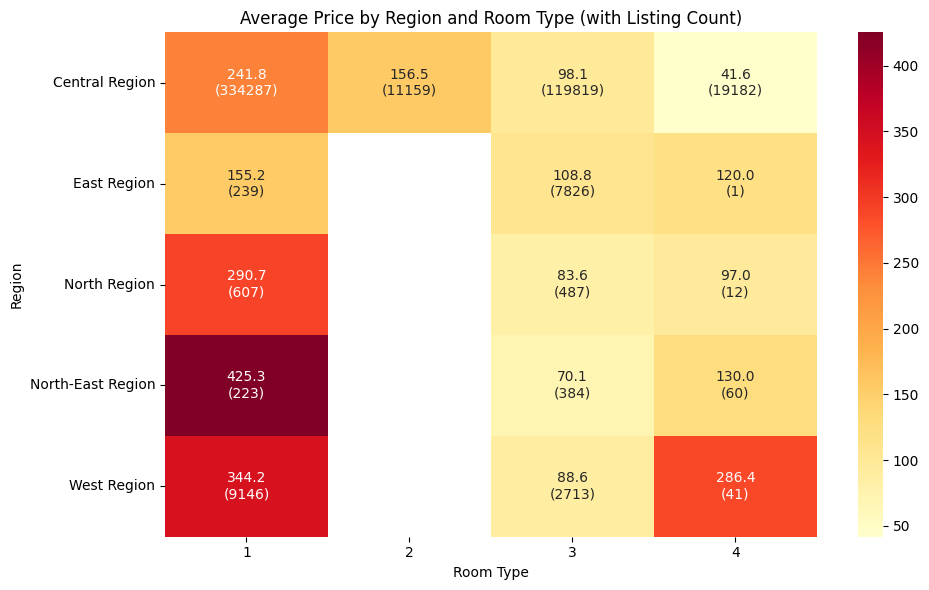

In [ ]:
# remove outliers from 'price' using IQR method
Q1 = df_combi3['price'].quantile(0.25)
Q3 = df_combi3['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_combi3[(df_combi3['price'] >= lower_bound) & (df_combi3['price'] <= upper_bound)]

# create pivot table
pivot_occ = df_filtered.pivot_table(
    index='neighbourhood_group_cleansed',
    columns='room_type',
    values='price',
    aggfunc='mean'
)

# count of listings per cell (after outlier removal)
pivot_counts = df_filtered.pivot_table(
    index='neighbourhood_group_cleansed',
    columns='room_type',
    values='price',
    aggfunc='count'
)

# create custom annotations: "avg\n(count)"
annot_data = pivot_occ.round(1).astype(str) + "\n(" + pivot_counts.fillna(0).astype(int).astype(str) + ")"

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_occ, annot=annot_data, fmt='', cmap='YlOrRd')
plt.title('Average Price by Region and Room Type (with Listing Count)')
plt.xlabel('Room Type')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

## Faceting - Visualizing number_of_reviews vs. price vs. host_is_superhost vs.neighbourhood_group_cleansed

<ipython-input-52-713bd8b38661>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[df_combi3['number_of_reviews'] < 200]


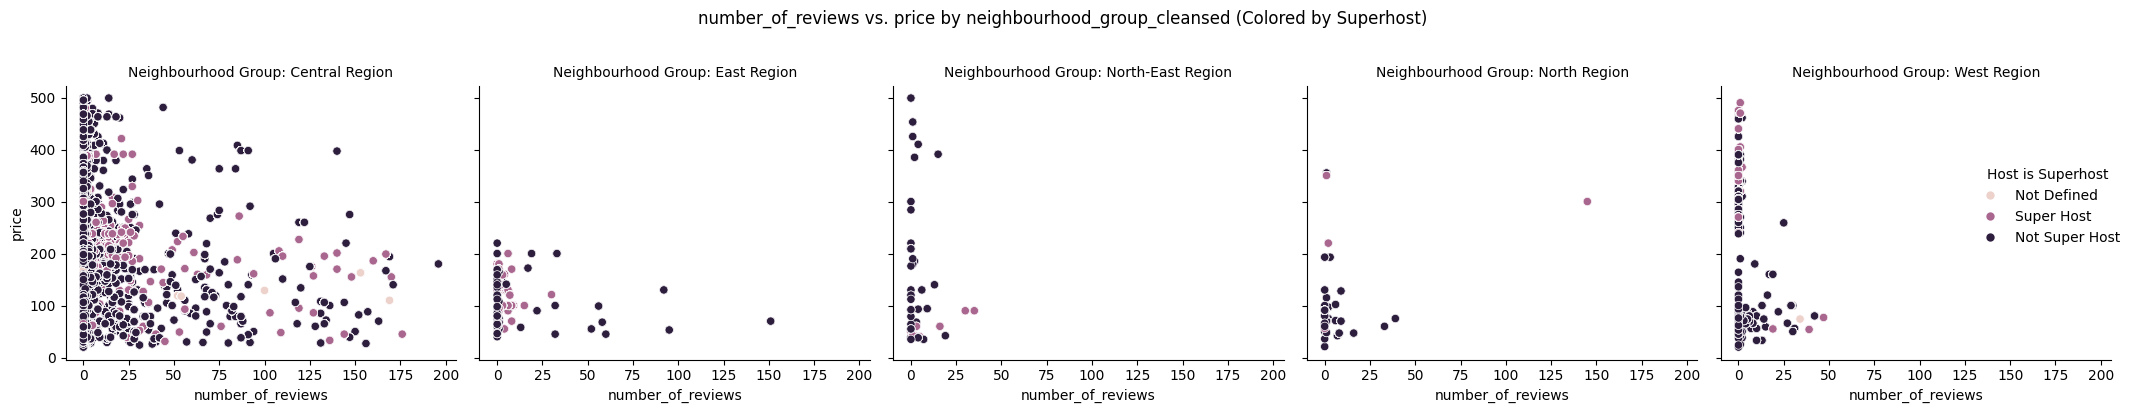

In [ ]:
# create the faceted scatter plot using seaborn's relplot
## filter data to include only listings with price less than 500 & reviews less than 200
df_filtered = df_combi3[df_combi3['price'] < 500]
df_filtered = df_filtered[df_combi3['number_of_reviews'] < 200]

g1 = sns.relplot(data=df_filtered,
                    x='number_of_reviews',
                    y='price',
                    col='neighbourhood_group_cleansed',  # facet by neighbourhood group
                    hue='host_is_superhost',  # color points by superhost status
                    kind='scatter',
                    height=4,  # adjust the height of each facet
                    aspect=1)  # adjust the aspect ratio of each facet

# set titles and labels
x_col = 'number_of_reviews'
y_col = 'price'
group_col = 'neighbourhood_group_cleansed'
g1.fig.suptitle(f'{x_col} vs. {y_col} by {group_col} (Colored by Superhost)', y=1.02)
g1.set_axis_labels('number_of_reviews', 'price')
g1.set_titles("Neighbourhood Group: {col_name}")

# adjust legend title
g1.legend.set_title("Host is Superhost")
new_labels = ['Not Defined','Super Host', 'Not Super Host']
for t, l in zip(g1._legend.texts, new_labels):
        t.set_text(l)

plt.tight_layout()
plt.show()

## bar - max nights

<ipython-input-73-c6fccb816f19>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['max_nights_bin'] = pd.cut(df_temp['maximum_nights'], bins=bins, labels=labels)
<ipython-input-73-c6fccb816f19>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('max_nights_bin').agg(


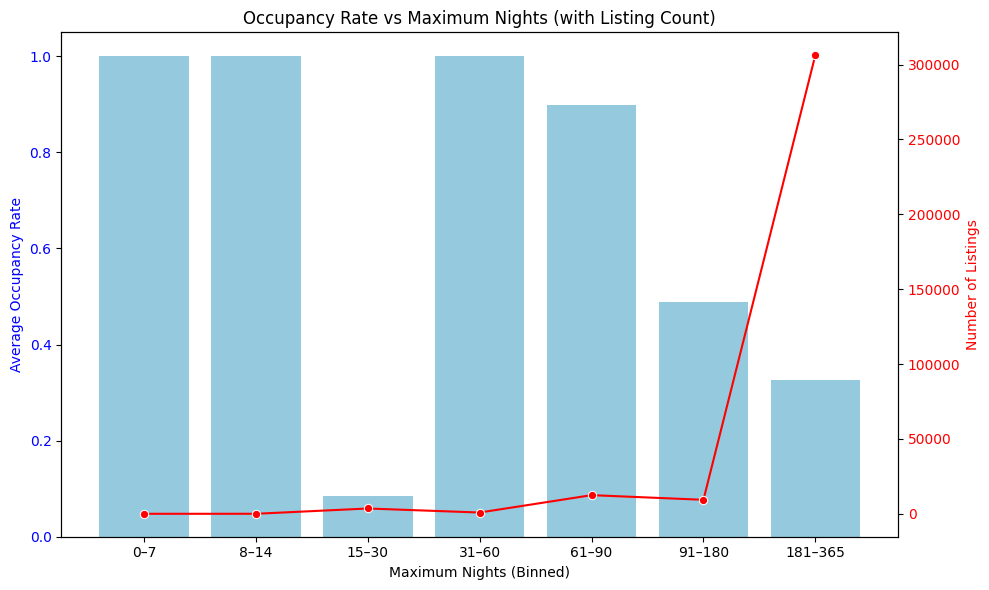

In [ ]:
# Filter to avoid extreme outliers
df_temp = df_combi3[df_combi3['maximum_nights'] <= 365]

# Create bins for maximum nights
bins = [0, 7, 14, 30, 60, 90, 180, 365]
labels = ['0–7', '8–14', '15–30', '31–60', '61–90', '91–180', '181–365']
df_temp['max_nights_bin'] = pd.cut(df_temp['maximum_nights'], bins=bins, labels=labels)

# Group and calculate mean occupancy and count
grouped = df_temp.groupby('max_nights_bin').agg(
    avg_occupancy=('occupancy_rate', 'mean'),
    count=('occupancy_rate', 'count')
).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar for occupancy
sns.barplot(x='max_nights_bin', y='avg_occupancy', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Average Occupancy Rate', color='blue')
ax1.set_xlabel('Maximum Nights (Binned)')
ax1.set_title('Occupancy Rate vs Maximum Nights (with Listing Count)')
ax1.tick_params(axis='y', labelcolor='blue')

# Line for count (secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='max_nights_bin', y='count', data=grouped, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Number of Listings', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

<ipython-input-77-27f10c4c55cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['min_nights_bin'] = pd.cut(df_temp['minimum_nights'], bins=bins, labels=labels)
<ipython-input-77-27f10c4c55cf>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('min_nights_bin').agg(


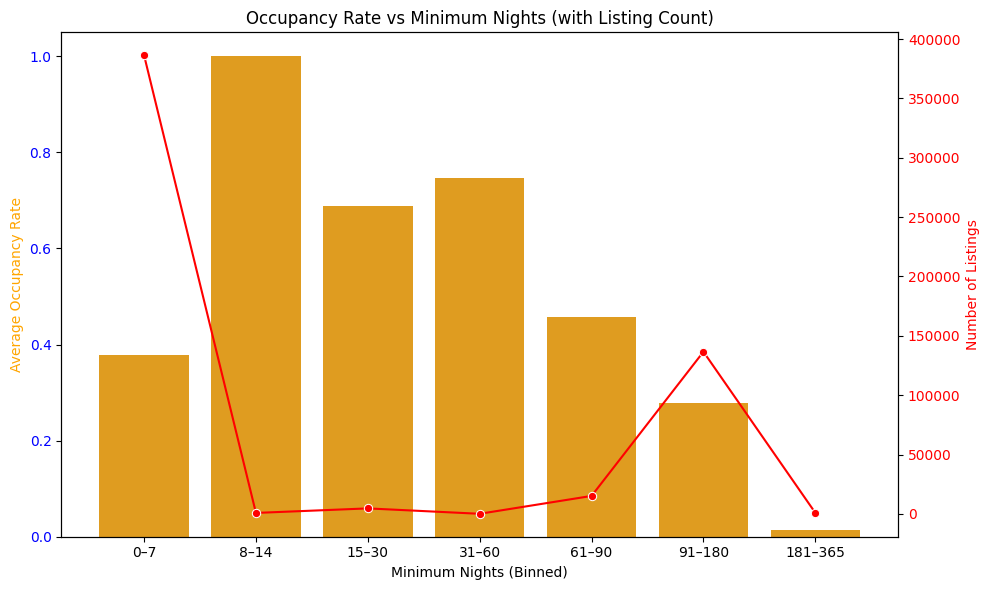

In [ ]:
# Filter to avoid extreme outliers
df_temp = df_combi3[df_combi3['minimum_nights'] <= 365]

# Create bins for maximum nights
bins = [0, 7, 14, 30, 60, 90, 180, 365]
labels = ['0–7', '8–14', '15–30', '31–60', '61–90', '91–180', '181–365']
df_temp['min_nights_bin'] = pd.cut(df_temp['minimum_nights'], bins=bins, labels=labels)

# Group and calculate mean occupancy and count
grouped = df_temp.groupby('min_nights_bin').agg(
    avg_occupancy=('occupancy_rate', 'mean'),
    count=('occupancy_rate', 'count')
).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar for occupancy
sns.barplot(x='min_nights_bin', y='avg_occupancy', data=grouped, ax=ax1, color='orange')
ax1.set_ylabel('Average Occupancy Rate', color='orange')
ax1.set_xlabel('Minimum Nights (Binned)')
ax1.set_title('Occupancy Rate vs Minimum Nights (with Listing Count)')
ax1.tick_params(axis='y', labelcolor='blue')

# Line for count (secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='min_nights_bin', y='count', data=grouped, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Number of Listings', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

## barchart - reveiws score ratings

<ipython-input-78-cdd18ebb46c5>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('acceptance_bin').agg(


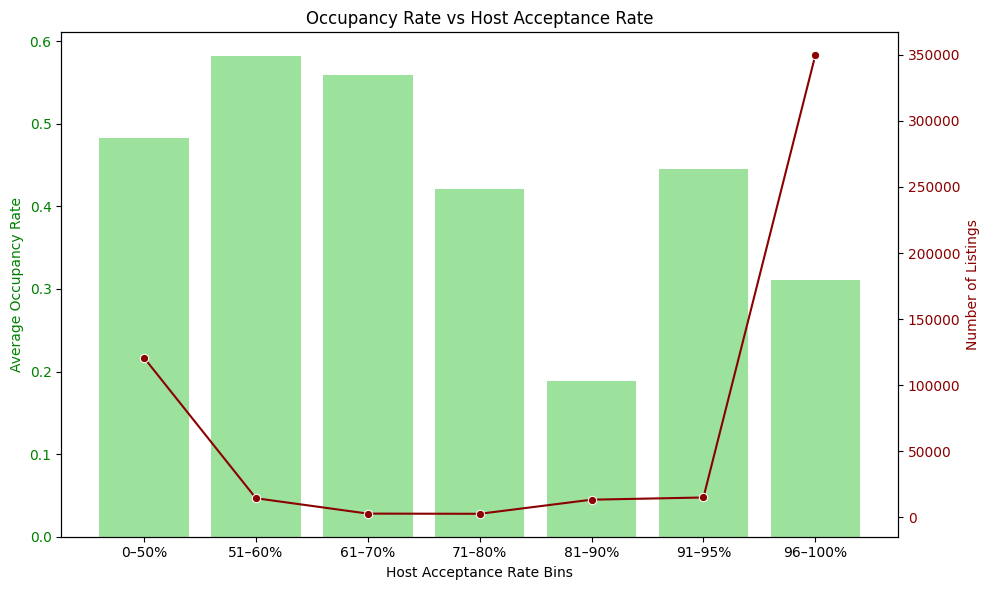

In [ ]:
# filter out extreme or null values if needed
df_temp = df_combi3[df_combi3['host_acceptance_rate'].between(0, 100)]

# create bins for acceptance rate
bins = [0, 50, 60, 70, 80, 90, 95, 100]
labels = ['0–50%', '51–60%', '61–70%', '71–80%', '81–90%', '91–95%', '96–100%']
df_temp['acceptance_bin'] = pd.cut(df_temp['host_acceptance_rate'], bins=bins, labels=labels)

# group by bin to compute average occupancy and listing count
grouped = df_temp.groupby('acceptance_bin').agg(
    avg_occupancy=('occupancy_rate', 'mean'),
    count=('occupancy_rate', 'count')
).reset_index()

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# bar plot for average occupancy rate
sns.barplot(x='acceptance_bin', y='avg_occupancy', data=grouped, ax=ax1, color='lightgreen')
ax1.set_ylabel('Average Occupancy Rate', color='green')
ax1.set_xlabel('Host Acceptance Rate Bins')
ax1.set_title('Occupancy Rate vs Host Acceptance Rate')
ax1.tick_params(axis='y', labelcolor='green')

# line plot for number of listings (secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='acceptance_bin', y='count', data=grouped, ax=ax2, color='darkred', marker='o')
ax2.set_ylabel('Number of Listings', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

## Bar chart - Average Number of Reviews by Superhost Status in Each Neighbourhood

In [ ]:
# group by neighbourhood and superhost status, then calculate the average number of reviews
average_reviews = df_combi3.groupby(['neighbourhood_cleansed', 'host_is_superhost'])['number_of_reviews'].mean().reset_index()
average_reviews.head()

,neighbourhood_cleansed,host_is_superhost,number_of_reviews
0,Ang Mo Kio,1,2.800000
1,Ang Mo Kio,2,6.000000
2,Bedok,1,6.366278
3,Bedok,2,34.980278
4,Bishan,2,0.246602


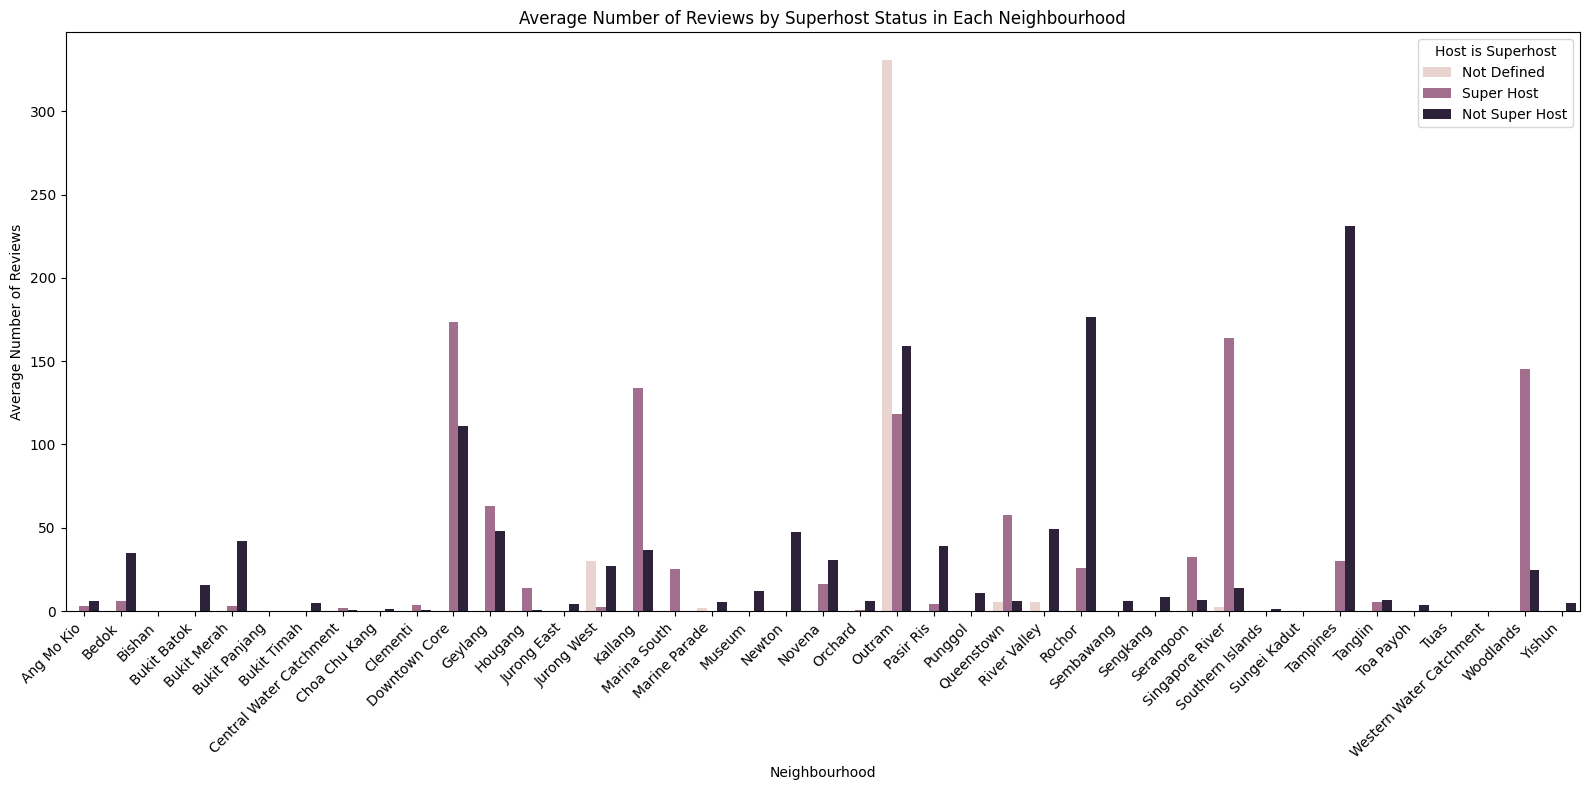

In [ ]:
# create the bar chart
plt.figure(figsize=(16, 8))
g = sns.barplot(x='neighbourhood_cleansed', y='number_of_reviews', hue='host_is_superhost', data=average_reviews)
plt.title(f'Average Number of Reviews by Superhost Status in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Number of Reviews')
plt.xticks(rotation=45, ha='right')

## adjust legend title
legend = g.get_legend()
legend.set_title("Host is Superhost")
new_labels = ['Not Defined','Super Host', 'Not Super Host']
for t, l in zip(legend.texts, new_labels):
      t.set_text(l)
plt.tight_layout()
plt.show()

# Listing Performance Evaluation Prototype

In [ ]:
# # Iterative Improvement (How to test??)

# # Track Changes (Simplified - Requires a more robust system in production)
# listing_changes = {}  # Dictionary to store changes (id: [changes])

# def track_change(listing_id, change_description):
#     if listing_id not in listing_changes:
#         listing_changes[listing_id] = []
#     listing_changes[listing_id].append(change_description)

# # Simulate a change (e.g., price adjustment)
# track_change(12345, "Price reduced by 10%")  # Replace 12345 with a real listing ID

# # Monitor Performance (Simplified - Requires a more robust monitoring system)
# def monitor_performance(new_data):
#     # Retrain model with new data
#     X_new = new_data.drop(columns=['occupancy_rate', 'availability_365'])
#     y_new = new_data['occupancy_rate']
#     model.fit(X_new, y_new)

#     # Evaluate on new data
#     y_pred_new = model.predict(X_new)
#     mae_new = mean_absolute_error(y_new, y_pred_new)
#     r2_new = r2_score(y_new, y_pred_new)
#     print(f"\nNew Data Performance: MAE={mae_new}, R²={r2_new}")

# # Simulate new data arrival and re-train model (In a real scenario, this would be scheduled regularly)
# # new_data = pd.read_csv('new_data.csv') #Load new data.
# # monitor_performance(new_data)